In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.utils import save_image
import os
from datasets import load_dataset
from jupyter_server.transutils import trans

In [12]:
os.environ["HF_DATASETS_CACHE"] = "E:/DataSets/HuggingFace/cache"
os.environ["HF_HOME"] = "E:/DataSets/HuggingFace/cache"
os.environ["HUGGINGFACE_HUB_CACHE"] = "E:/DataSets/HuggingFace/cache"
os.environ["TRANSFORMERS_CACHE"] = "E:/DataSets/HuggingFace/cache"
dataset = load_dataset("svjack/pokemon-blip-captions-en-zh", split="train")

In [13]:
dataset

Dataset({
    features: ['image', 'en_text', 'zh_text'],
    num_rows: 833
})

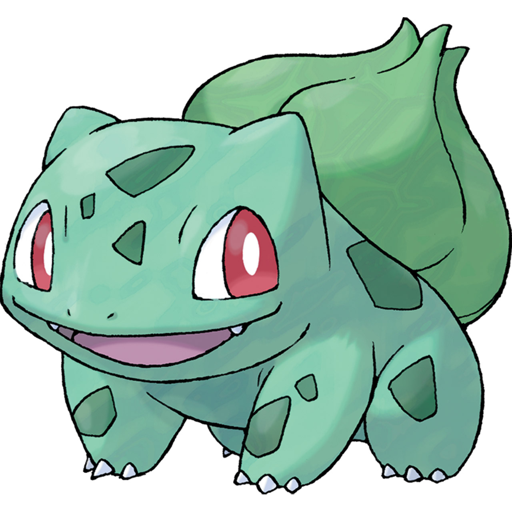

In [14]:
dataset[0]["image"].resize((512, 512))

In [17]:
class VAE(nn.Module):
    def __init__(self, in_channels=3, latent_dim=4, image_size=512):
        """
        输入：[3, 512, 512]
        :param in_channels: 通道数
        :param latent_dim: 潜在空间维度
        :param image_size: 图像大小
        """
        super(VAE, self).__init__()
        self.in_channels = in_channels
        self.latent_dim = latent_dim
        self.image_size = image_size
        
        # Encoder: [3, 512, 512] -> [4, 64, 64]
        self.encoder = nn.Sequential(
            self._conv_block(in_channels, 32),     # [32, 256, 256]
            self._conv_block(32, 64),           # [64, 128, 128]
            self._conv_block(64, 128),          # [128, 64, 64]
        )
        self.mu = nn.Conv2d(128, latent_dim, kernel_size=1)
        self.log_var = nn.Conv2d(128, latent_dim, kernel_size=1)
        
        # Decoder: [4, 64, 64] -> [3, 512, 512]
        self.decoder = nn.Sequential(
            nn.Conv2d(latent_dim, 128, kernel_size=1),  # [128, 64, 64]
            self._conv_transpose_block(128, 64),        # [64, 128, 128]
            self._conv_transpose_block(64, 32),         # [32, 256, 256]
            self._conv_transpose_block(32, in_channels) # [3, 512, 512]
        )
    
    @staticmethod
    def _conv_block(in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1),
            nn.GroupNorm(num_groups=1, num_channels=out_channels),      # layer norm < group norm < batch norm
            nn.LeakyReLU(0.2),
        )
    
    @staticmethod
    def _conv_transpose_block(in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.GroupNorm(num_groups=1, num_channels=out_channels),
            nn.LeakyReLU(0.2),
        )
    
    def encode(self, x):
        result = self.encoder(x)
        return self.mu(result), self.log_var(result)
    
    def decode(self, z):
        result = self.decoder(z)
        result = nn.Tanh()(result)
        return result.view(-1, self.in_channels, self.image_size, self.image_size)
    
    @staticmethod
    def reparameterize(mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        """
        :param x: input image
        :return: reconstruction, x, mu, log_var
        """
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)    # 重参数化，得到潜在空间的表示 [4, 64, 64]
        return self.decoder(z), x, mu, log_var

In [18]:
# hyperparameters
batch_size = 32
lr = 0.001
epochs = 100
image_size = 512
latent_dim = 4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.RandomHorizontalFlip(),    # 随机水平翻转，增强数据集
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]),    # map to [-1, 1]
])

In [19]:
def transform_all(data):
    images = [transform(image.convert('RGB')) for image in data["image"]]
    en_texts = data["en_text"]
    return {"image": images, "en_text": en_texts}

dataset.set_transform(transform_all)

In [ ]:
train_dataset = dataset.select(range(0, 600))
val_dataset = dataset.select(range(600, 800))
train_data_loder = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)
val_data_loder = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=4)

vae = VAE(in_channels=3, latent_dim=latent_dim, image_size=image_size).to(device)
optimizer = optim.Adam(vae.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, min_lr=5e-5)

def loss_function(recon_x, x, mu, log_var):
    MSE = F.mse_loss(recon_x, x, reduction='sum')   # mean square error
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp()) # KL 散度
    return MSE + KLD

if not os.path.exists("./models/vae"):
    os.makedirs("./models/vae")

best_loss = float('inf')
early_stop_patience = 30
no_improvement = 0

for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for i, batch in enumerate(train_data_loder):
        images = batch["image"].to(device)
        optimizer.zero_grad()
        
        recon_batch, x, mu, log_var = vae(images)
        loss = loss_function(recon_batch, images, mu, log_var)
        
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if i % 10 == 9:
            print(f"Train Epoch: {epoch+1}/{epochs}\n\t[{i * len(images)}/{len(train_data_loder.dataset)} ({100. * i / len(train_data_loder):.0f}%)]\n\tLoss: {loss.item() / len(images):.6f}")
    print(f'====> Epoch: {epoch+1} Average loss: {train_loss / len(train_data_loder.dataset):.4f} lr: {optimizer.param_groups[0]["lr"]}')
    
    vae.eval()
    val_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(val_data_loder):
            images = batch["image"].to(device)
            recon_batch, x, mu, log_var = vae(images)
            loss = loss_function(recon_batch, images, mu, log_var)
            val_loss += loss.item()
    val_loss /= len(val_data_loder.dataset)
    print(f'====> Validation loss: {val_loss:.4f}')
    
    scheduler.step(val_loss)
    
    if epoch % 10 == 9:
        with torch.no_grad():
            B = images.size(0)
            n = min(B, 8)
            comparison = torch.cat([images[:n],
                                    recon_batch.view(batch_size, 3, image_size, image_size)[:n]])
            comparison = (comparison * 0.5) + 0.5    # map to [0, 1]
            save_image(comparison.cpu(), f"./models/vae/reconstruction_{epoch+1}.png", nrow=n)

torch.save(vae.state_dict(), "./models/vae/vae.pth")
print("Model saved and training finished.")